# Procesamiento
Vamos a utilizar sklearn para el procesamiento de datos mediante pipelines.
- Buena info de cómo hacer esto aquí: https://www.youtube.com/watch?v=0B5eIE_1vpU&t=1227s

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

train = pd.read_csv('data/train_data.csv')
test = pd.read_csv('data/test_data.csv')

In [2]:
# Vamos a definir los datos de entrenamiento
X = train.drop(['mineralType', 'id'], axis=1)
y = train['mineralType']

In [3]:
# Create sklearn pipeline for data preprocessing
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer, recall_score, precision_score
import numpy as np

preprocessor = ColumnTransformer([
        # (name, transformer, columns)
        ("temperatureFirstHalfPlanetRotation", FunctionTransformer(lambda f: (f - 32) / 1.8, feature_names_out="one-to-one"), ['temperatureFirstHalfPlanetRotation']), # convert from Fahrenheit to Celsius
        ("temperatureSecondHalfPlanetRotation", "passthrough", ['temperatureSecondHalfPlanetRotation']), # pass through the column unchanged
        ("waterStreamDistanceX", FunctionTransformer(lambda f: f * 0.3048, feature_names_out="one-to-one"), ['waterStreamDistanceX']), # convert from feet to meters
        ("waterStreamDistanceY", "passthrough", ['waterStreamDistanceY']), # pass through the column unchanged
        ("planetSection", OneHotEncoder(handle_unknown = "ignore"), ['planetSection']), # one-hot encode the planetSection column
        ("cover", OneHotEncoder(handle_unknown='error', drop='first'), ['cover']), # one-hot encode the cover column and drop the first column (the one with the missing values == 0)
        ("climaticZone", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), ['climaticZone']), # ordinal encode the climaticZone column TODO: drop category 3? what to do? only one row has a 3
        ("geoZone", OneHotEncoder(handle_unknown = "ignore"), ['geoZone']), # one-hot encode the geoZone column TODO: drop category 5?
        ("rockSize", OneHotEncoder(handle_unknown='ignore', drop='first'), ['rockSize']), # one-hot encode the rockSize column and drop the first column (the one with the missing values == 0)
        ("magmaConcentrationDistance", OneHotEncoder(handle_unknown = "ignore"), ['magmaConcentrationDistance']), # one-hot encode the rockSize column and drop the first column (the one with the missing values == 0) TODO: use Ordinal Encoder?
        ("mineralDensity", "passthrough", ['mineralDensity']), # pass through the column unchanged
        ("detectionDepth", "passthrough", ['detectionDepth']), # pass through the column unchanged TODO: convert km to m?
        ("longitude", "passthrough", ['longitude']), # pass through the column unchanged TODO: values > 360? do x - 360
    ],
    verbose_feature_names_out=False, remainder='drop'
)

model = KNeighborsClassifier()

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

grid = GridSearchCV(pipe, cv=5, scoring=['accuracy', 'precision_macro'], error_score='raise', return_train_score=True, n_jobs=-1, verbose=1, refit='accuracy',
            param_grid={
                'model__n_neighbors': [5, 8, 10, 12, 15, 20],
                'model__weights': ['uniform', 'distance'],
                'model__metric': ['euclidean', 'manhattan']
            })
grid.fit(X, y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('temperatureFirstHalfPlanetRotation',
                                                                         FunctionTransformer(feature_names_out='one-to-one',
                                                                                             func=<function <lambda> at 0x7fcad631fc20>),
                                                                         ['temperatureFirstHalfPlanetRotation']),
                                                                        ('temperatureSecondHalfPlanetRotation',
                                                                         'passthrough',
                                                                         ['temperatureSe...
                                                                         ['detectionDepth']),
                              

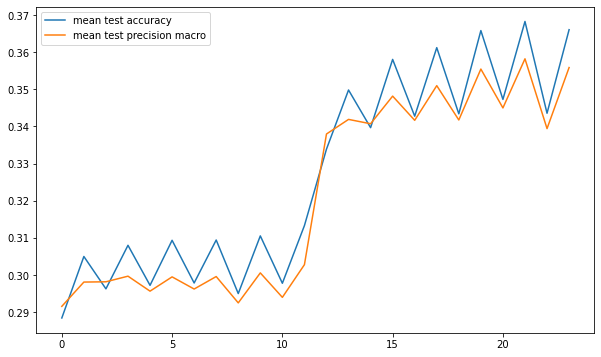

In [4]:
# Plot the results of the grid search to see which parameters are the best for the model to use
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(grid.cv_results_['mean_test_accuracy'], label='mean test accuracy')
plt.plot(grid.cv_results_['mean_test_precision_macro'], label='mean test precision macro')
plt.legend()
plt.show()

In [5]:
grid.best_params_

{'model__metric': 'manhattan',
 'model__n_neighbors': 15,
 'model__weights': 'distance'}

In [6]:
grid.best_score_

0.36827603521049407

In [7]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__metric,param_model__n_neighbors,param_model__weights,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_train_accuracy,split1_train_accuracy,split2_train_accuracy,split3_train_accuracy,split4_train_accuracy,mean_train_accuracy,std_train_accuracy,split0_test_precision_macro,split1_test_precision_macro,split2_test_precision_macro,split3_test_precision_macro,split4_test_precision_macro,mean_test_precision_macro,std_test_precision_macro,rank_test_precision_macro,split0_train_precision_macro,split1_train_precision_macro,split2_train_precision_macro,split3_train_precision_macro,split4_train_precision_macro,mean_train_precision_macro,std_train_precision_macro
0,0.110588,0.010964,0.607475,0.008654,euclidean,5,uniform,"{'model__metric': 'euclidean', 'model__n_neigh...",0.284356,0.276545,0.294374,0.293185,0.293582,0.288409,0.006962,24,0.516640,0.515599,0.510449,0.510152,0.515103,0.513589,0.002732,0.287154,0.279228,0.296160,0.298173,0.296975,0.291538,0.007289,24,0.527009,0.525072,0.520688,0.520125,0.525584,0.523695,0.002765
1,0.101811,0.028913,0.374398,0.036887,euclidean,5,distance,"{'model__metric': 'euclidean', 'model__n_neigh...",0.301386,0.298732,0.312995,0.307448,0.304279,0.304968,0.004955,18,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.294966,0.292600,0.305226,0.300843,0.296770,0.298081,0.004475,19,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
2,0.068120,0.003596,0.576026,0.021159,euclidean,8,uniform,"{'model__metric': 'euclidean', 'model__n_neigh...",0.290297,0.290808,0.301109,0.305864,0.293185,0.296253,0.006172,22,0.466125,0.468159,0.459542,0.457066,0.455383,0.461255,0.005027,0.291393,0.289869,0.303776,0.309028,0.296708,0.298155,0.007298,18,0.476074,0.476228,0.468319,0.464930,0.462547,0.469620,0.005640
3,0.078448,0.009878,0.364771,0.024728,euclidean,8,distance,"{'model__metric': 'euclidean', 'model__n_neigh...",0.298614,0.305864,0.314976,0.309826,0.310618,0.307980,0.005505,17,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.289732,0.298182,0.306646,0.302379,0.301393,0.299666,0.005656,15,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
4,0.070675,0.004300,0.591106,0.015730,euclidean,10,uniform,"{'model__metric': 'euclidean', 'model__n_neigh...",0.291485,0.291997,0.300713,0.310222,0.291601,0.297204,0.007389,21,0.445325,0.447163,0.433495,0.437853,0.435278,0.439823,0.005454,0.287976,0.289559,0.299852,0.311314,0.289478,0.295636,0.008912,21,0.449559,0.452571,0.436298,0.441354,0.439741,0.443904,0.006145
5,0.077912,0.012460,0.379747,0.025261,euclidean,10,distance,"{'model__metric': 'euclidean', 'model__n_neigh...",0.298614,0.303487,0.310618,0.321712,0.312203,0.309327,0.007902,16,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.288777,0.294580,0.300342,0.313586,0.300108,0.299479,0.008230,17,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
6,0.070858,0.006850,0.589485,0.014100,euclidean,12,uniform,"{'model__metric': 'euclidean', 'model__n_neigh...",0.292277,0.294374,0.301109,0.300713,0.300713,0.297837,0.003746,19,0.433340,0.426562,0.424582,0.426265,0.424879,0.427126,0.003200,0.288218,0.293747,0.300147,0.299067,0.299852,0.296206,0.004623,20,0.437723,0.430007,0.427857,0.429258,0.428366,0.430642,0.003617
7,0.071693,0.001837,0.387648,0.011476,euclidean,12,distance,"{'model__metric': 'euclidean', 'model__n_neigh...",0.299406,0.305071,0.316957,0.310222,0.315372,0.309406,0.006513,15,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.289493,0.295702,0.307408,0.300418,0.304819,0.299568,0.006422,16,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
8,0.080340,0.004083,0.631621,0.013329,euclidean,15,uniform,"{'model__metric': 'euclidean', 'model__n_neigh...",0.291881,0.295959,0.295959,0.299921,0.291204,0.294985,0.003168,23,0.412738,0.413

In [8]:
preprocessed_data = preprocessor.fit_transform(X)

preprocessed_dataframe = pd.DataFrame(preprocessed_data, columns=preprocessor.get_feature_names_out())
preprocessed_dataframe

,temperatureFirstHalfPlanetRotation,temperatureSecondHalfPlanetRotation,waterStreamDistanceX,waterStreamDistanceY,planetSection_Hyrule,planetSection_Mordor,planetSection_Tatoooine,cover_1,cover_2,cover_3,cover_4,climaticZone,geoZone_1,geoZone_2,geoZone_5,geoZone_7,rockSize_1,rockSize_2,rockSize_3,magmaConcentrationDistance_CLOSE,magmaConcentrationDistance_FAR,magmaConcentrationDistance_MEDIUM,magmaConcentrationDistance_VERY_CLOSE,magmaConcentrationDistance_VERY_FAR,mineralDensity,detectionDepth,longitude
0,-572.777778,28.9,261.426960,16.76,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,4617.64,27.49,71.86
1,39.444444,36.8,31.479744,12.13,0.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9859.22,27.30,360.78
2,44.388889,33.0,31.315152,1.90,0.0,1.0,0.0,0.0,0.0,1.0,0.0,6.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-999.00,32.25,37.66
3,42.444444,25.5,41.269920,11.89,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,-999.00,22.35,134.36
4,44.222222,29.5,0.000000,0.00,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3991.21,23.19,109.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12616,35.888889,21.4,42.022776,9.94,0.0,1.0,0.0,0.0,0.0,1.0,0.0,6.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,10576.29,33.30,105.95
12617,43.777778,37.9,272.716752,40.10,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,6457.13,28.76,330.01
12618,43.611111,33.4,355.034088,20.10,0.0,1.0,0.0,0.0,0.0,1.0,0.0,5.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-999.00,31.89,29.92
12619,41.222222,36.8,1086.255384,211.54,0.0,0.0,1.0,0.0,0.0,1.0,0.0,5.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,10078.16,32.61,358.35


In [9]:
from sklearn import set_config

set_config(display='diagram')
grid

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('temperatureFirstHalfPlanetRotation',
                                                                         FunctionTransformer(feature_names_out='one-to-one',
                                                                                             func=<function <lambda> at 0x7fcad631fc20>),
                                                                         ['temperatureFirstHalfPlanetRotation']),
                                                                        ('temperatureSecondHalfPlanetRotation',
                                                                         'passthrough',
                                                                         ['temperatureSe...
                                                                         ['detectionDepth']),
                                                                        ('longitude',
                                                                         'passthrough',
                                                                         ['longitude'])],
                                                          verbose_feature_names_out=False)),
                                       ('model', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'model__metric': ['euclidean', 'manhattan'],
                         'model__n_neighbors': [5, 8, 10, 12, 15, 20],
                         'model__weights': ['uniform', 'distance']},
             refit='accuracy', return_train_score=True,
             scoring=['accuracy', 'precision_macro'], verbose=1)